In [1]:
%matplotlib inline

import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import trappy

from trace import Trace

# Results Collection

Results DBs are collected into a separate folder, one for each test, and grouped by scheduler.

In [2]:
RESULTS_DIR = '/home/vagrant/lisa/results'
BENCH = 'Android_WorkloadsExecution'
BASE_DIR = '{}/{}'.format(RESULTS_DIR, BENCH)

In [3]:
# This is the content of the results folder
!tree {BASE_DIR}

/home/vagrant/lisa/results/Android_WorkloadsExecution
|-- eas
|   |-- IOPerf_10
|   |   |-- data.csv
|   |   |-- platform.json
|   |   `-- trace.html
|   |-- UiBench_TrivialAnimation
|   |   |-- framestats.txt
|   |   |-- platform.json
|   |   `-- trace.html
|   `-- results.json
|-- energy.json
|-- energy_stats.json
|-- samples.csv
|-- samples_Device0.csv
|-- samples_Device1.csv
|-- sfreq
|   |-- IOPerf_10
|   |   |-- data.csv
|   |   |-- platform.json
|   |   `-- trace.html
|   |-- Jankbench_edit_text
|   |   |-- BenchmarkResults
|   |   `-- platform.json
|   |-- Jankbench_high_hitrate_text
|   |   |-- BenchmarkResults
|   |   `-- platform.json
|   |-- Jankbench_image_list_view
|   |   |-- BenchmarkResults
|   |   `-- platform.json
|   |-- Jankbench_list_view
|   |   |-- BenchmarkResults
|   |   |-- platform.json
|   |   `-- trace.html
|   |-- Jankbench_low_hitrate_text
|   |   |-- BenchmarkResults
|   |   `-- platform.json
|   |-- Jankbench_shadow_grid
|   |   |-- BenchmarkResults
| 

# Results loading

In [4]:
#SCHED = ['sfreq', 'sutil_pelt', 'sutil_walt']
SCHED = ['eas']
TEST = 'IOPerf_10'
    
df = None
# Load all dataset
for sched in SCHED:
    csv_file = os.path.join(BASE_DIR, sched, TEST, 'data.csv')
    print "Loading CSV [{}]...".format(csv_file)
    if df is not None:
        df = df.append(pd.DataFrame.from_csv(csv_file), ignore_index=True)
    else:
        df = pd.DataFrame.from_csv(csv_file)

Loading CSV [/home/vagrant/lisa/results/Android_WorkloadsExecution/eas/IOPerf_10/data.csv]...


## Report IOPerformance Measurements

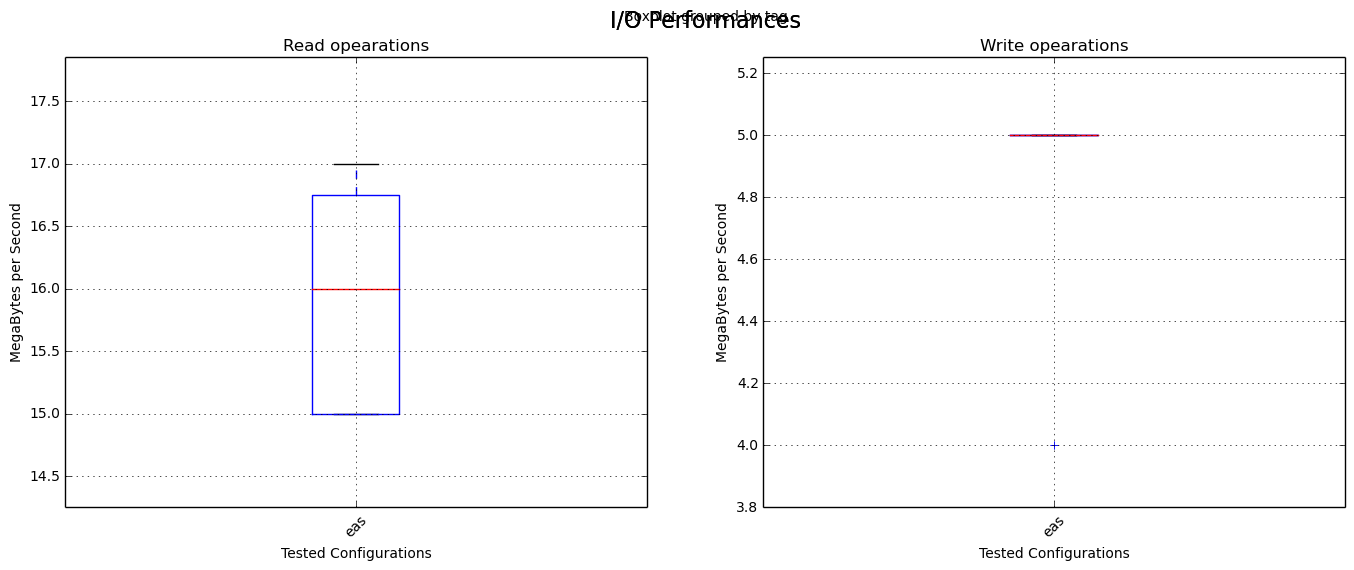

In [5]:
# Plot boxplot of collected data
fig, pltaxes = plt.subplots(1, 2, figsize=(16, 6));

# READ operations
axes = pltaxes[0]
data = df[df.operation == 'Read']

sfreq_mean = data[data.tag == 'sfreq'].MBps.mean()
axes.axhline(y=sfreq_mean, xmin=0, xmax=1, color='r', linestyle='dashed')

bp = data.boxplot(by=['tag'], column='MBps', ax=axes, return_type='dict');
axes.set_title('Read opearations');
axes.set_xlabel('Tested Configurations')
axes.set_ylabel('MegaBytes per Second')
xlabels = [item.get_text() for item in axes.xaxis.get_ticklabels()]
axes.set_xticklabels(xlabels, rotation=45)
ymin = data.MBps.min()
ymax = data.MBps.max()
axes.set_ylim(ymin*0.95, ymax*1.05)

# Write operations
axes = pltaxes[1]
data = df[df.operation == 'Write']

sfreq_mean = data[data.tag == 'sfreq'].MBps.mean()
axes.axhline(y=sfreq_mean, xmin=0, xmax=1, color='r', linestyle='dashed')

bp = data.boxplot(by=['tag'], column='MBps', ax=axes, return_type='dict');
axes.set_title('Write opearations');
axes.set_xlabel('Tested Configurations')
axes.set_ylabel('MegaBytes per Second')
xlabels = [item.get_text() for item in axes.xaxis.get_ticklabels()]
axes.set_xticklabels(xlabels, rotation=45)
ymin = data.MBps.min()
ymax = data.MBps.max()
axes.set_ylim(ymin*0.95, ymax*1.05)

fig.suptitle('I/O Performances', fontsize=16, horizontalalignment='center');

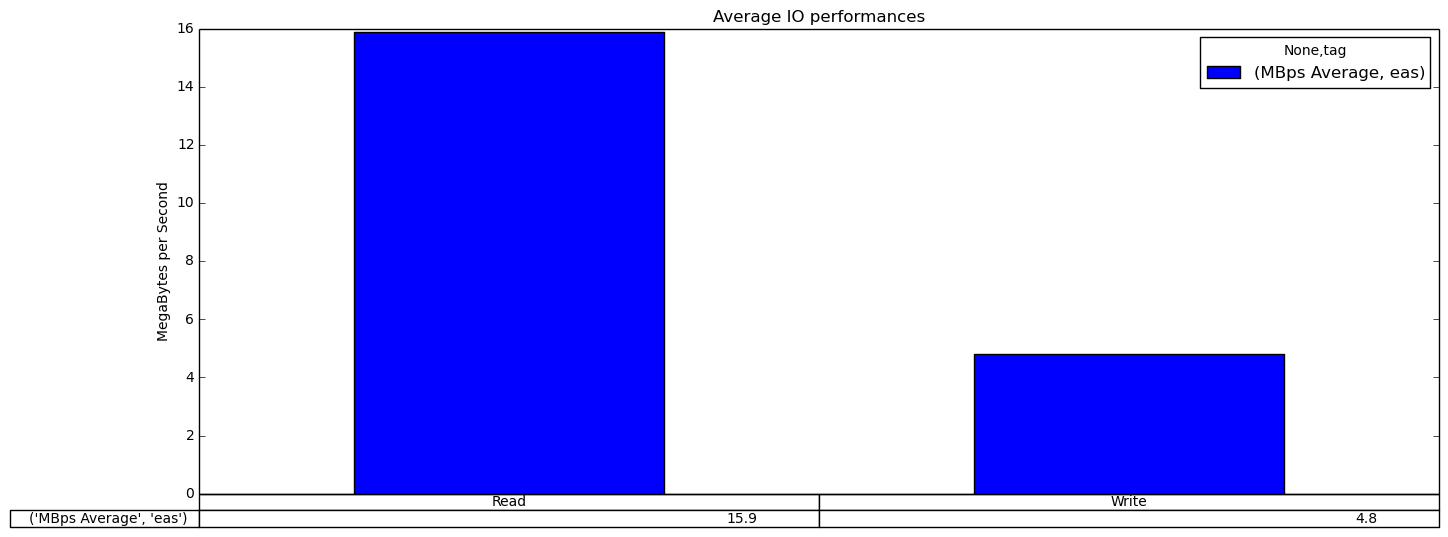

In [6]:
# Compute averages
avg = df.groupby(['operation', 'tag']).MBps.mean()
avg = pd.DataFrame(avg)
avg.rename(columns={'MBps' : 'MBps Average'}, inplace=True)
avg = avg.unstack()

# Plot averages
fig, axes = plt.subplots()
avg.plot(kind='bar', ax=axes,
           figsize=(16,6), legend=True,
           title="Average IO performances",
           table=True)
axes.set_ylabel("MegaBytes per Second")
axes.get_xaxis().set_visible(False)

# Parse collected traces

In [7]:
events = [
    "sched_switch",
    "sched_wakeup",
    "sched_wakeup_new",
    "sched_wakeup_tracking",

    "sched_stat_wait",

    "sched_overutilized",
    "sched_contrib_scale_f",
    "sched_load_avg_cpu",
    "sched_load_avg_task",
    "sched_tune_config",
    "sched_tune_filter",
    "sched_tune_tasks_update",
    "sched_tune_boostgroup_update",
    "sched_boost_cpu",
    "sched_boost_task",
    "sched_energy_diff",
    "cpu_capacity",
    "cpu_frequency",
    "cpu_idle",
    "walt_update_task_ravg",
    "walt_update_history",
    "walt_migration_update_sum",
]

In [9]:
# Parse all traces
trace = {}
ta = {}
for sched in SCHED:
    platform_file = os.path.join(BASE_DIR, sched, TEST, 'platform.json')
    with open(platform_file, 'r') as fh:
        platform = json.load(fh)
    trace_file = os.path.join(BASE_DIR, sched, TEST, 'trace.html')
    trace[sched] = Trace(platform, trace_file, events=events)

Maximum estimated system energy: 5584


## Overall view on DD tasks allocation for SchedFreq, SchedUtil with PELT and SchedUtil with WALT

In [10]:
# eas Trace
try:
    trappy.plotter.plot_trace(trace['eas'].ftrace, execnames=['dd'])
except: pass

In [ ]:
# sfreq Trace
try:
    trappy.plotter.plot_trace(trace['sfreq_trace'].ftrace, execnames=['dd'])
except: pass

In [ ]:
# sutil_walt Trace
try:
    trappy.plotter.plot_trace(trace['sutil_walt'].ftrace, execnames=['dd'])
except: pass

In [ ]:
# sutil_pelt Trace
try:
    trappy.plotter.plot_trace(trace['sutil_pelt'].ftrace, execnames=['dd'])
except: pass

## Cluster frequencies

Plotting cluster frequencies for [eas]...


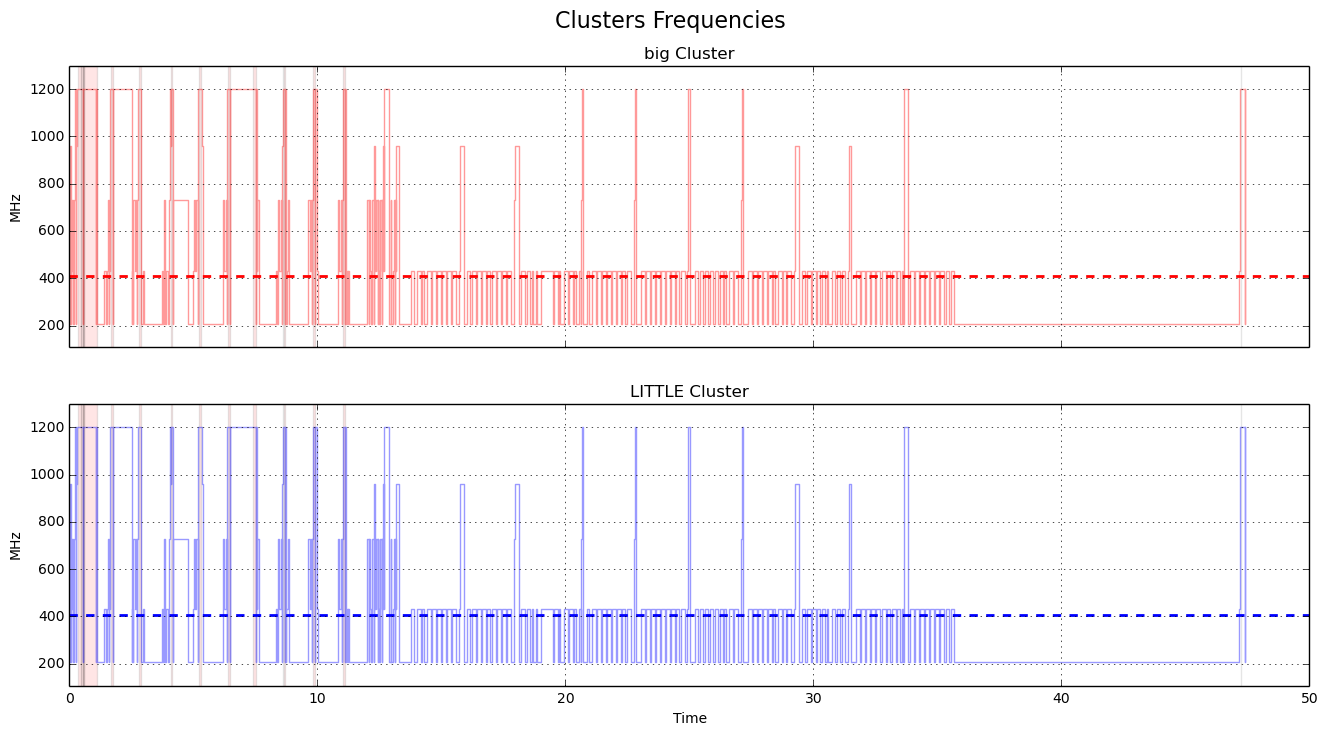

In [13]:
try:
    fa = trace['eas'].analysis.frequency
    fa.plotClusterFrequencies()
    print "Plotting cluster frequencies for [eas]..."
except: pass

In [ ]:
try:
    fa = trace['sfreq'].analysis.frequency
    fa.plotClusterFrequencies()
    print "Plotting cluster frequencies for [sfreq]..."
except: pass

In [ ]:
try:
    fa = trace['sutil_walt'].analysis.frequency
    fa.plotClusterFrequencies()
    print "Plotting cluster frequencies for [sutil_walt]..."
except: pass

In [ ]:
try:
    fa = trace['sutil_pelt'].analysis.frequency
    fa.plotClusterFrequencies()
    print "Plotting cluster frequencies for [sutil_pelt]..."
except: pass

## Tasks signals

Plotting dd task for [eas]...


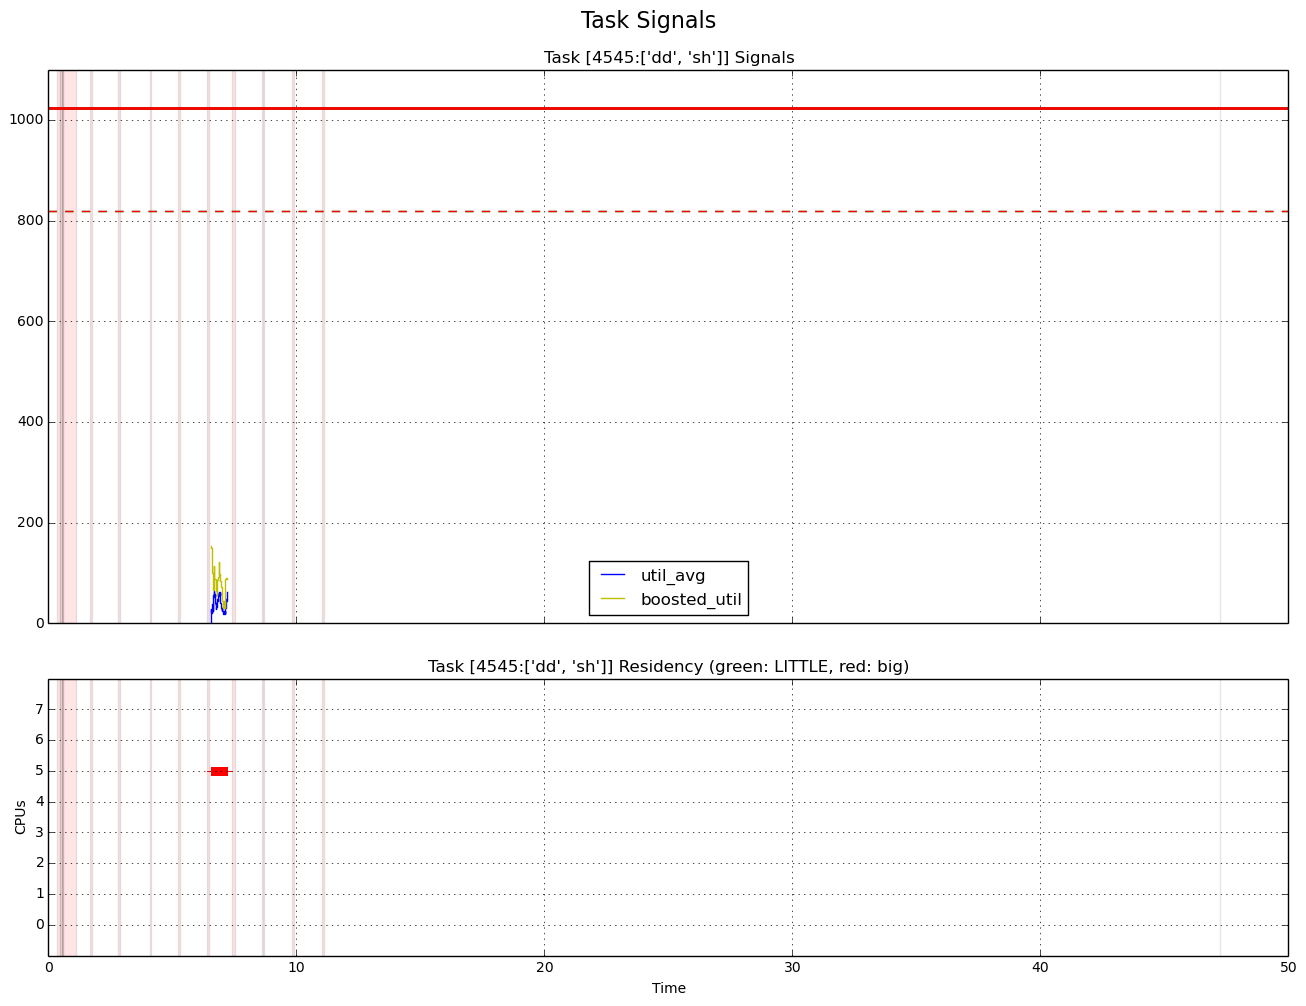

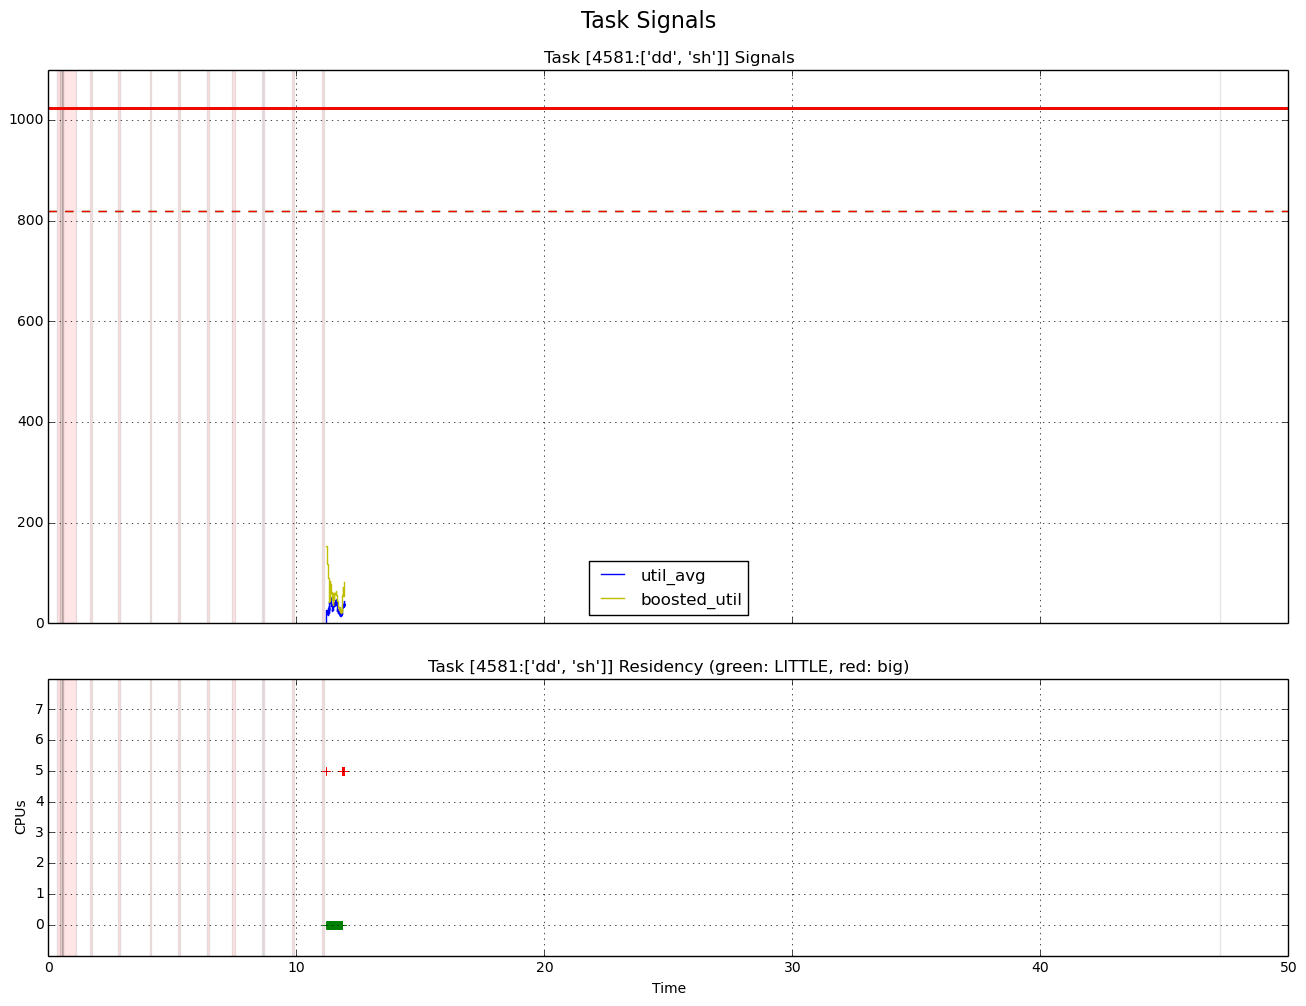

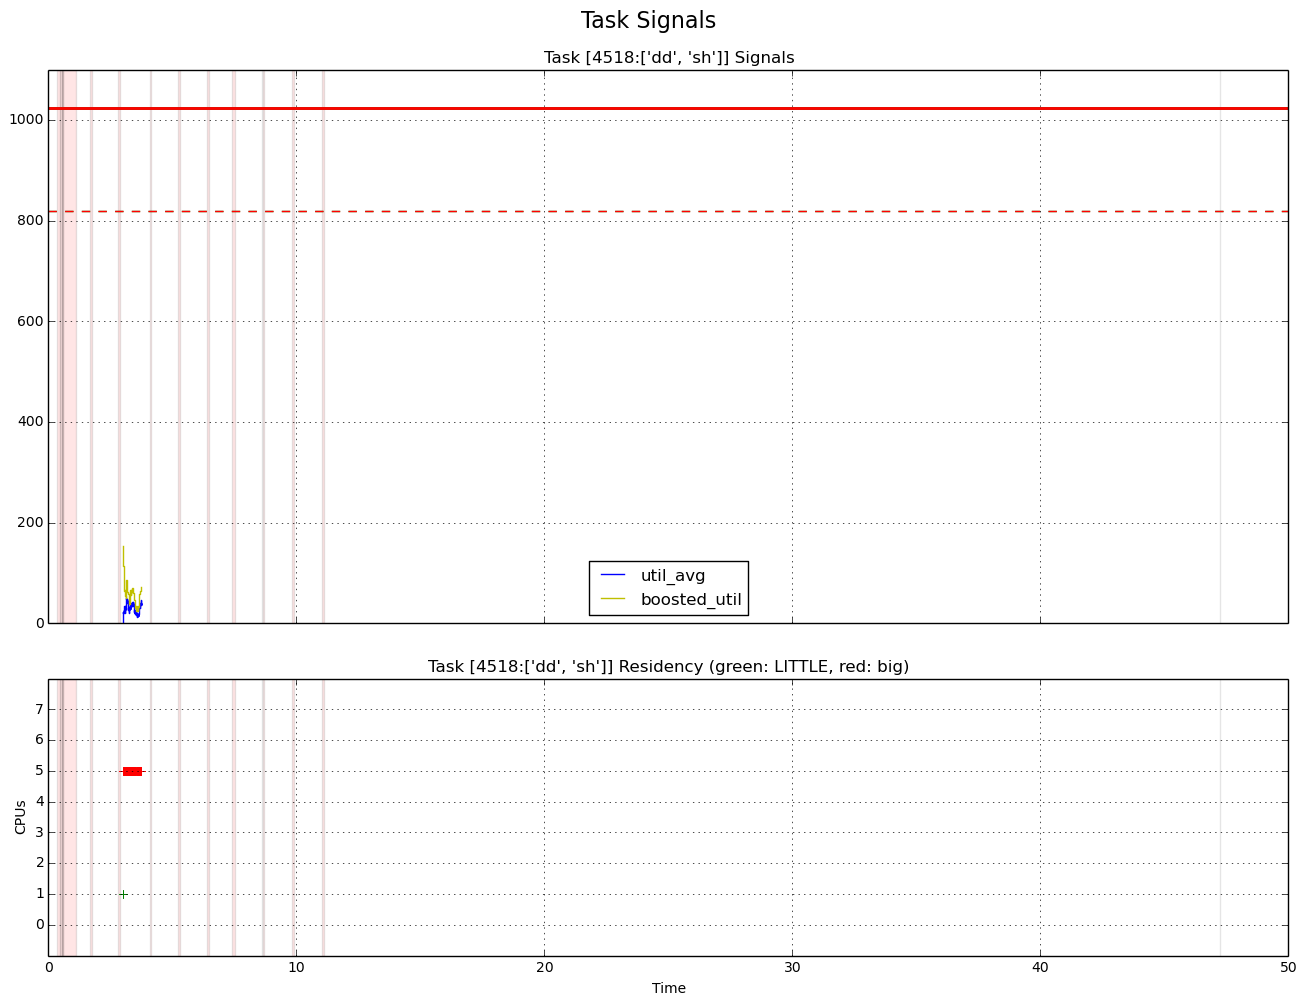

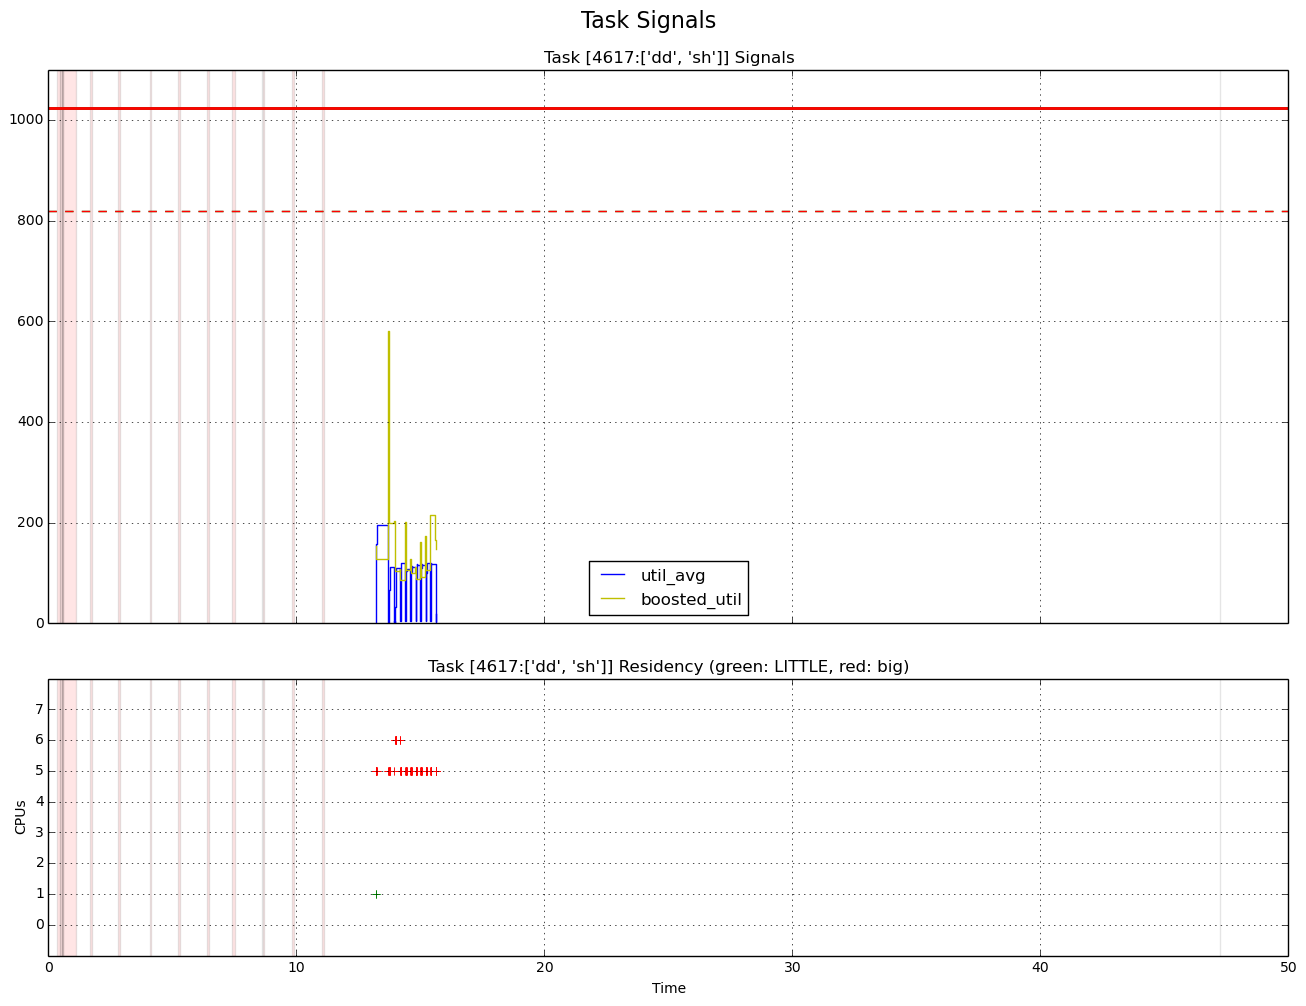

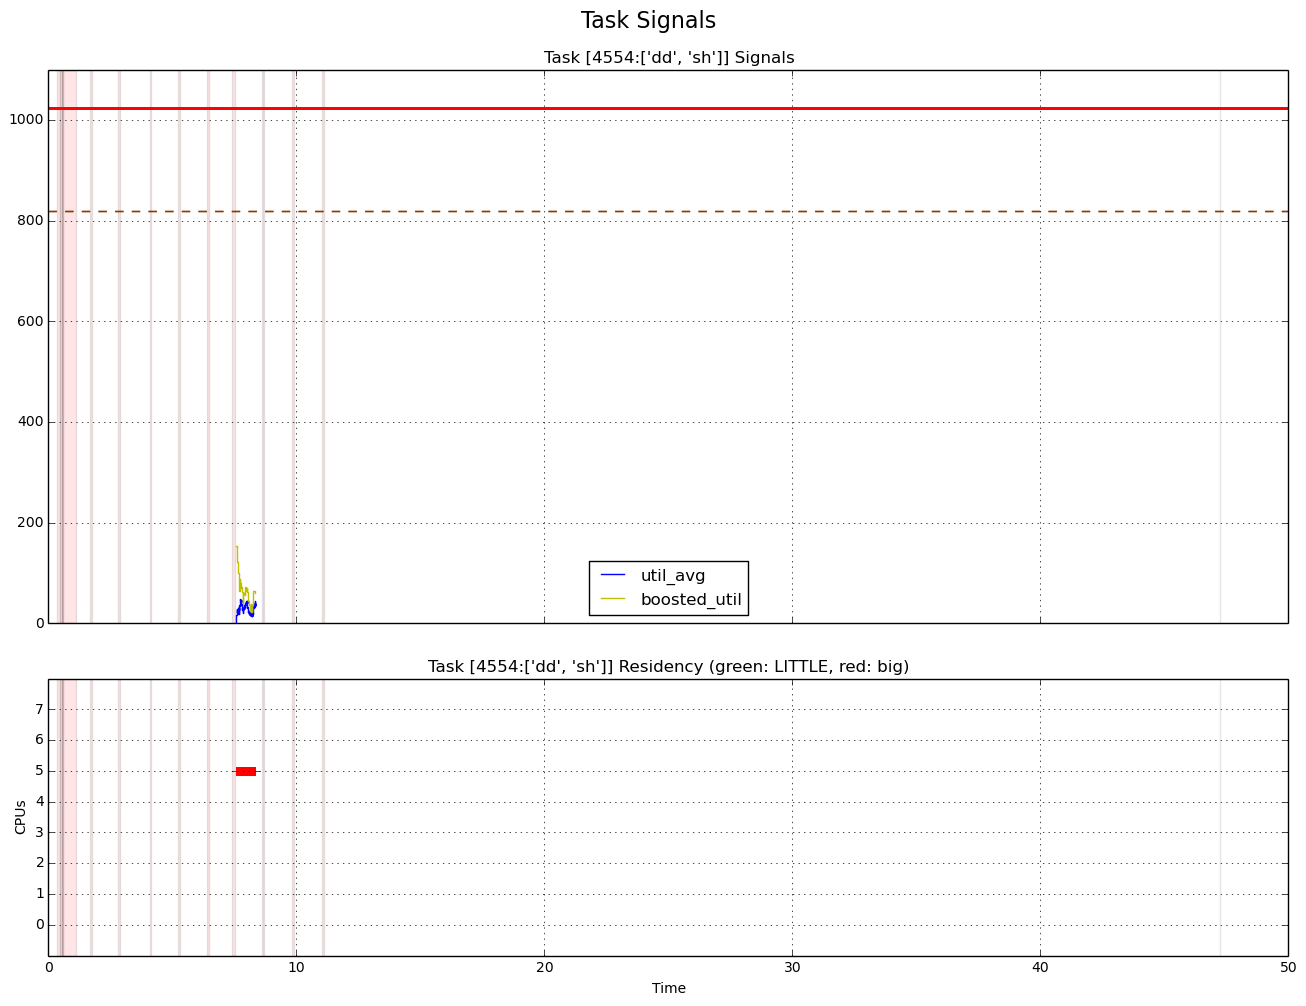

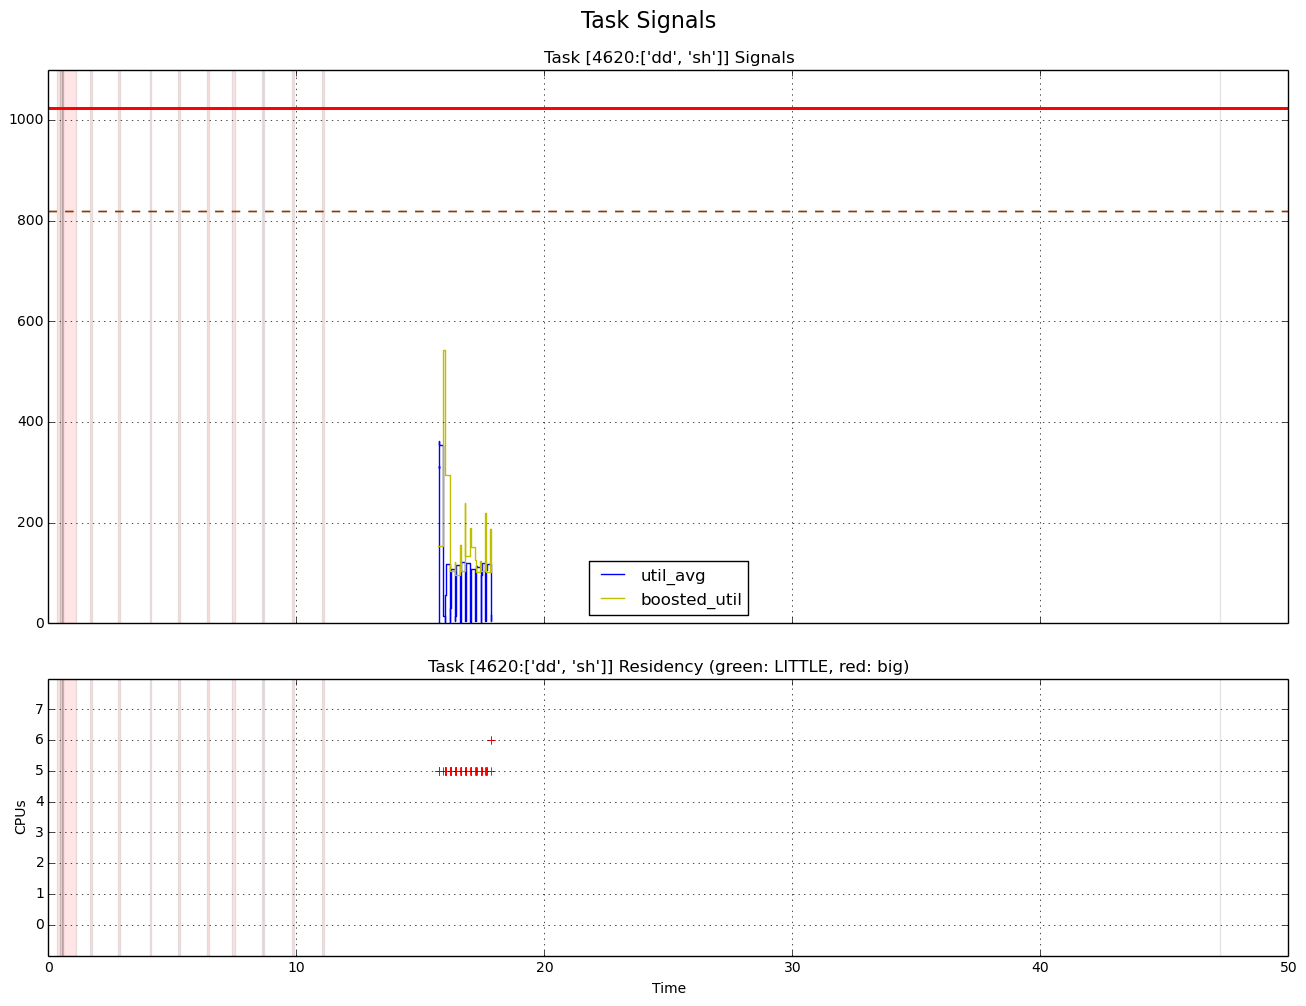

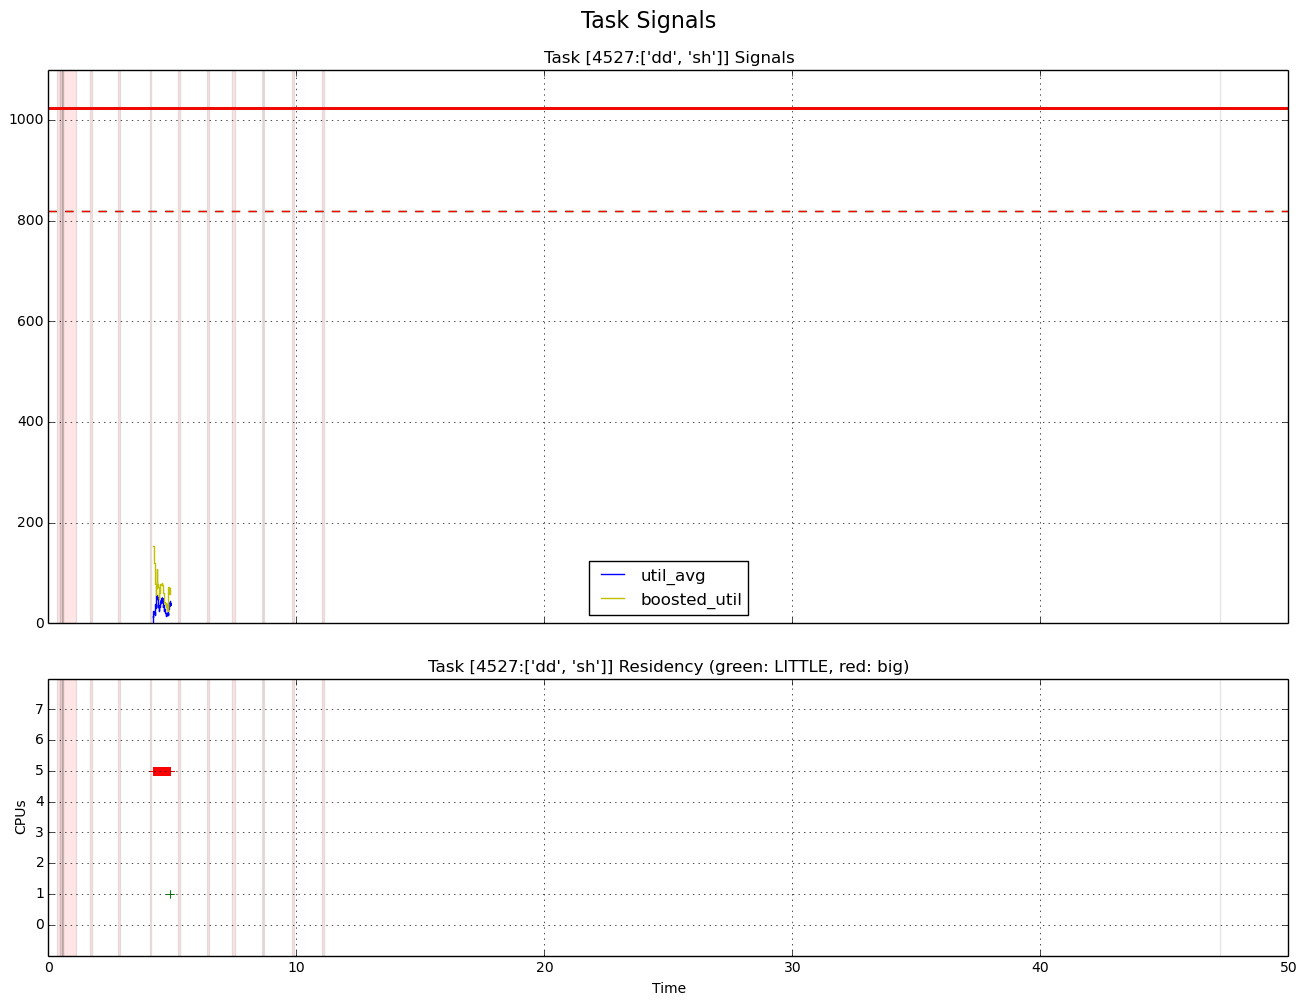

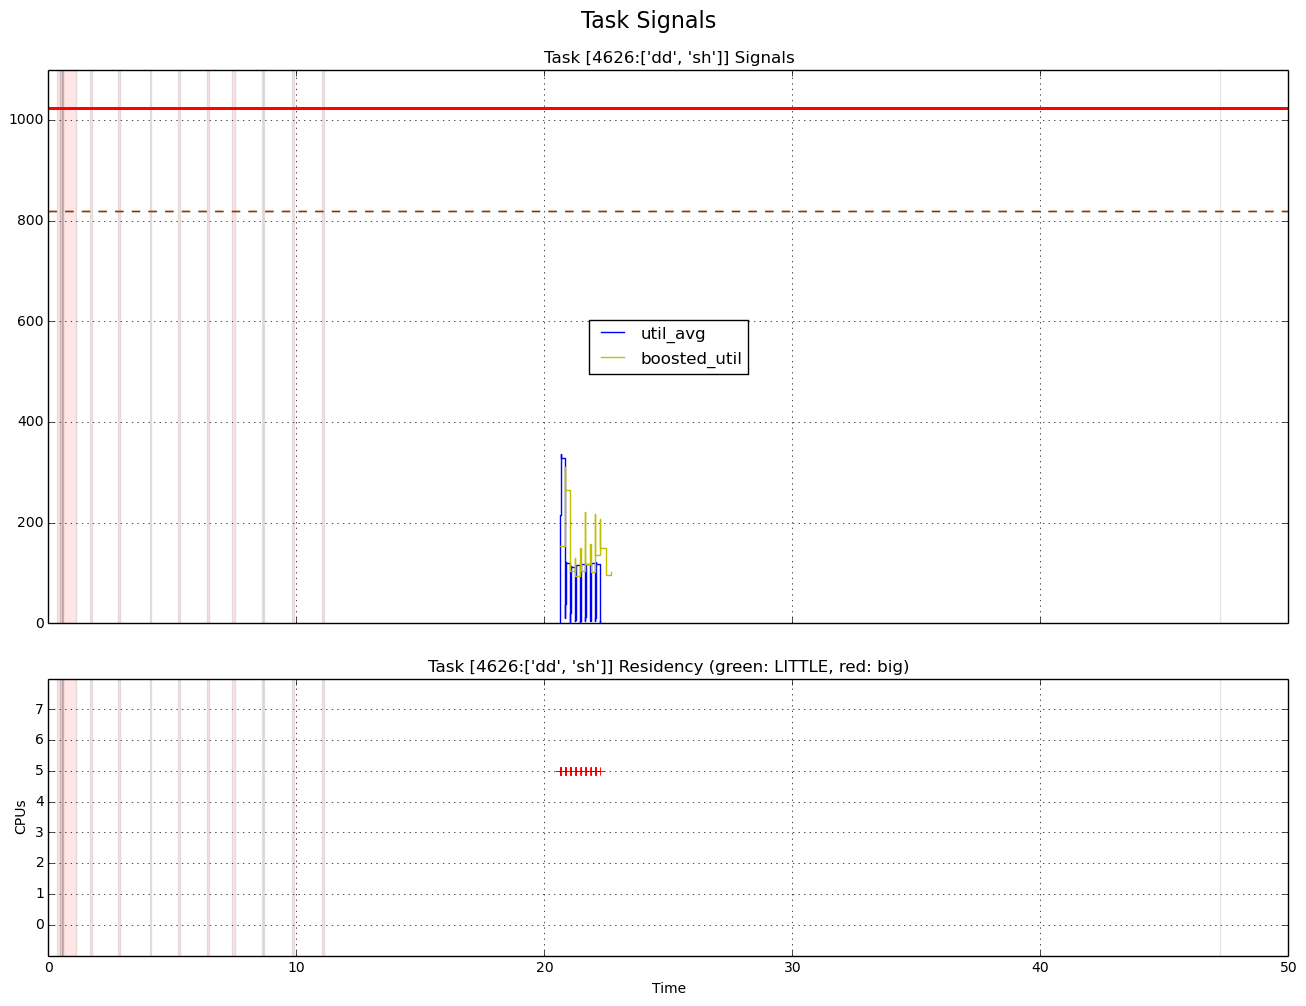

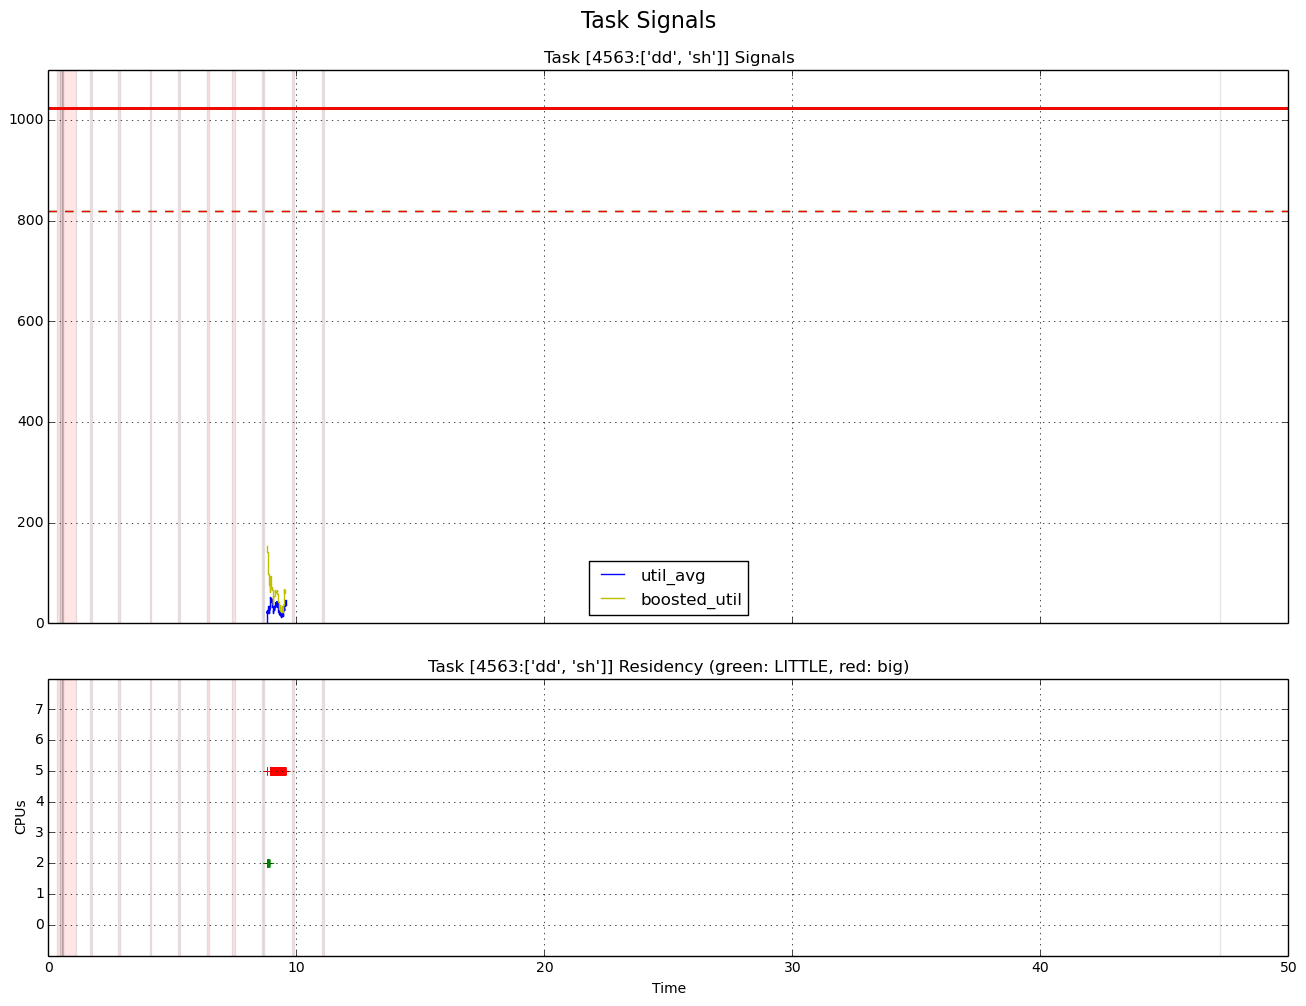

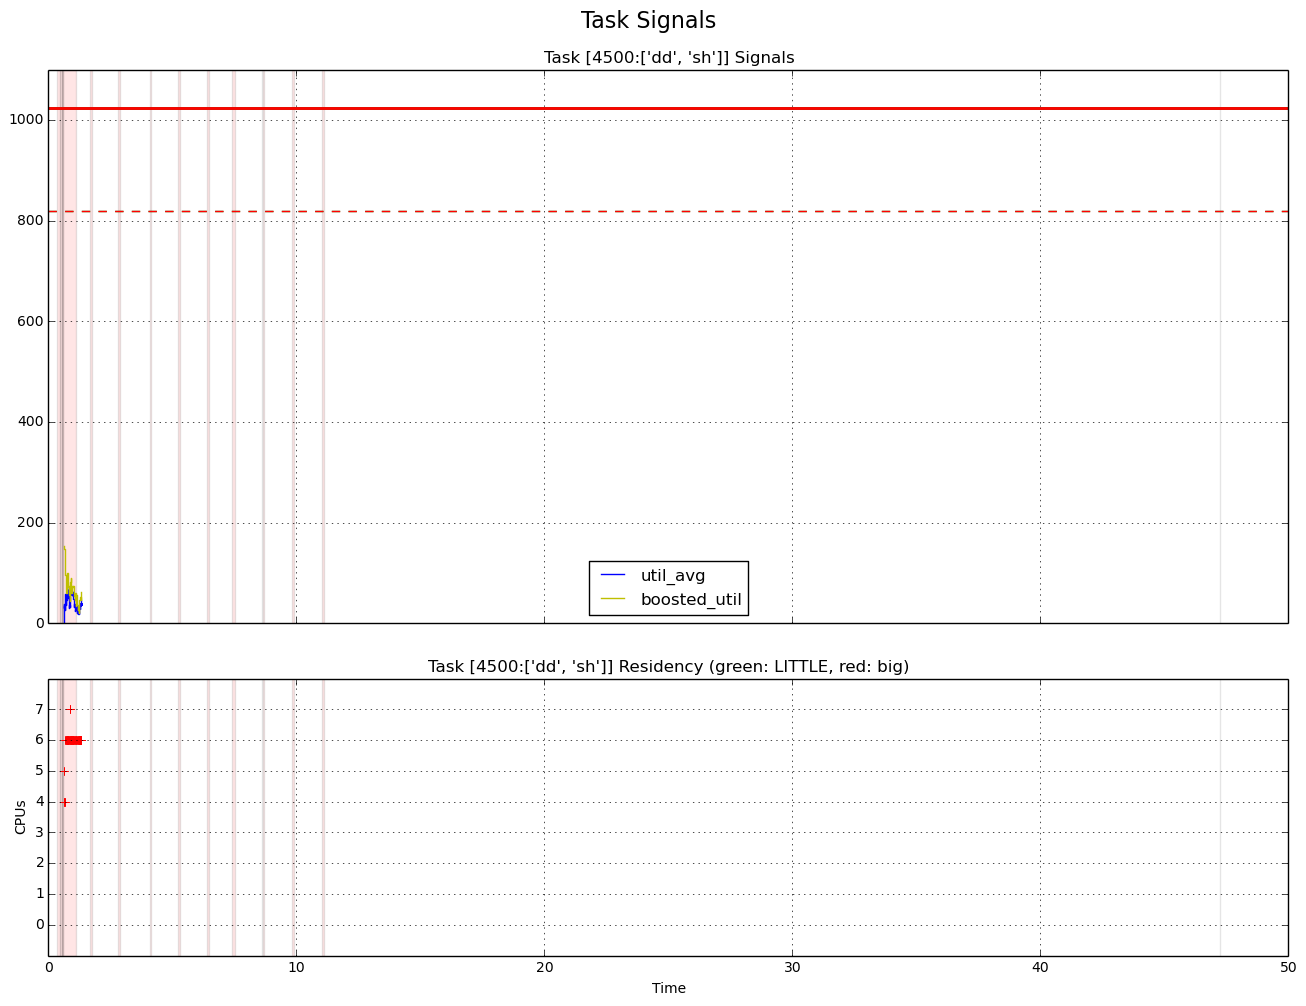

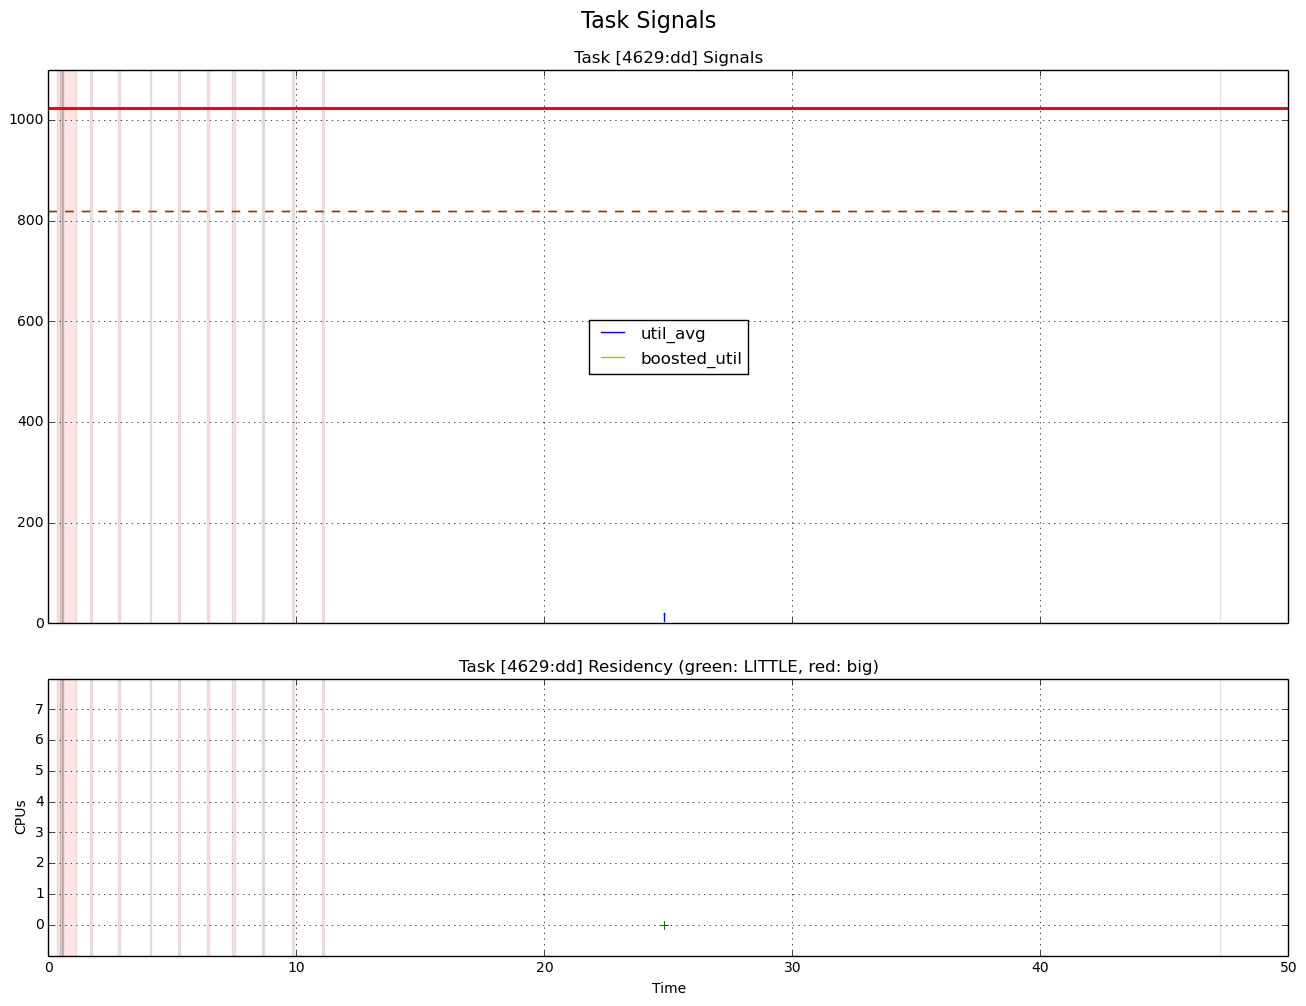

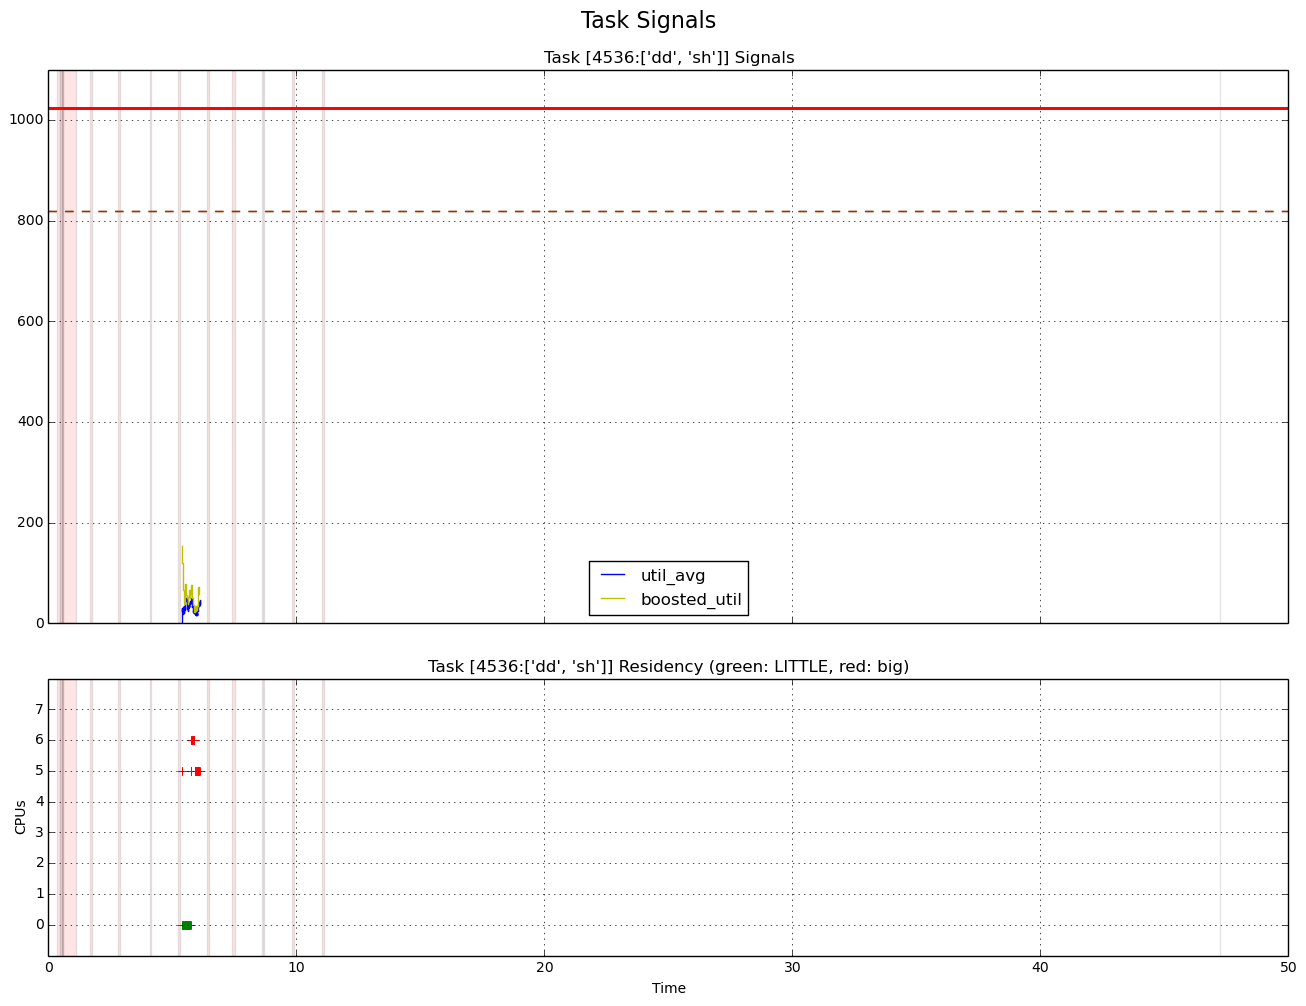

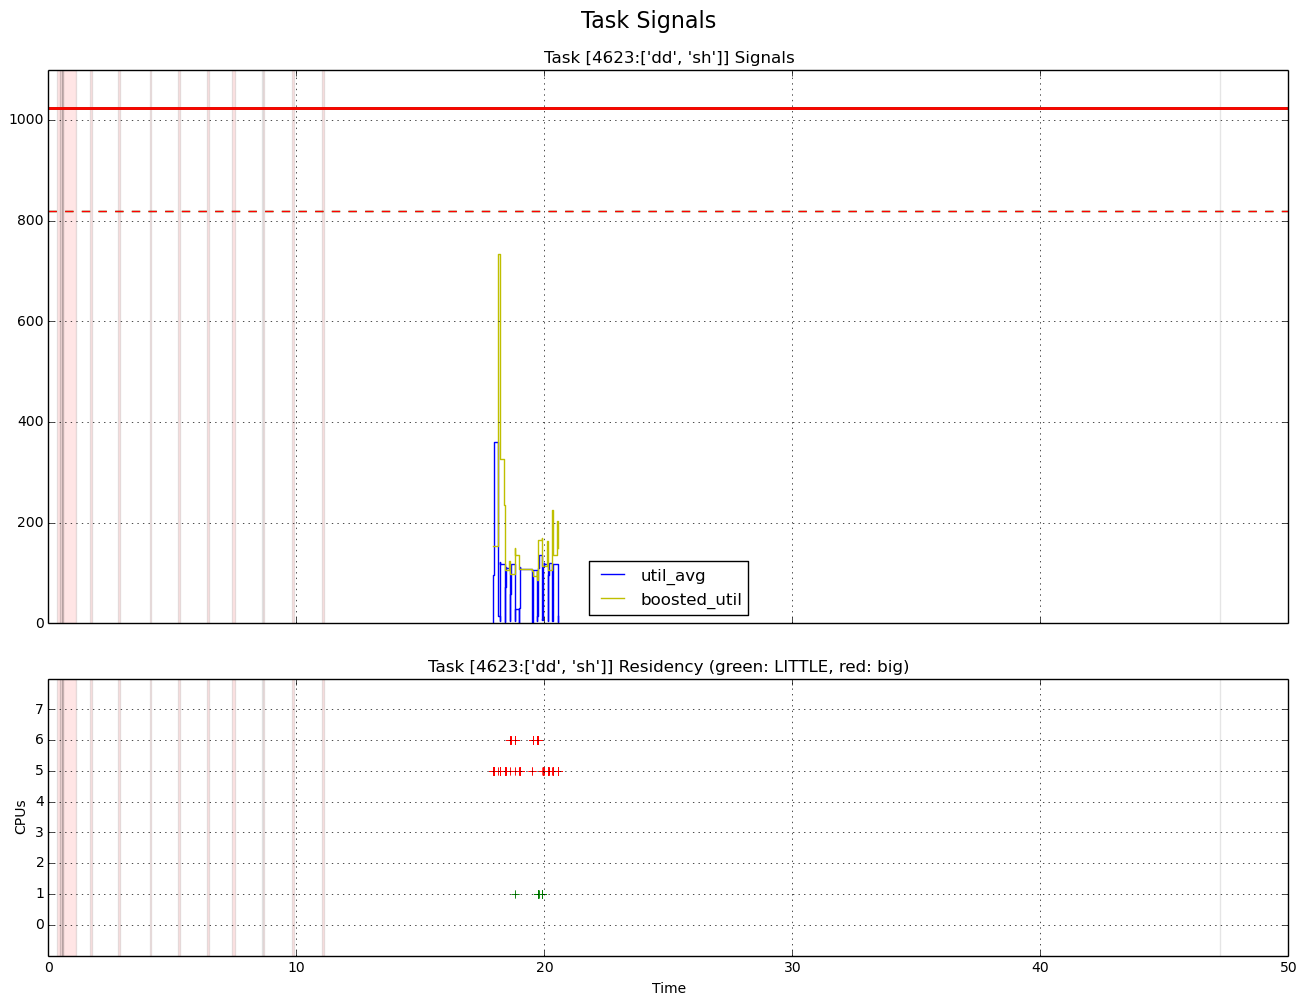

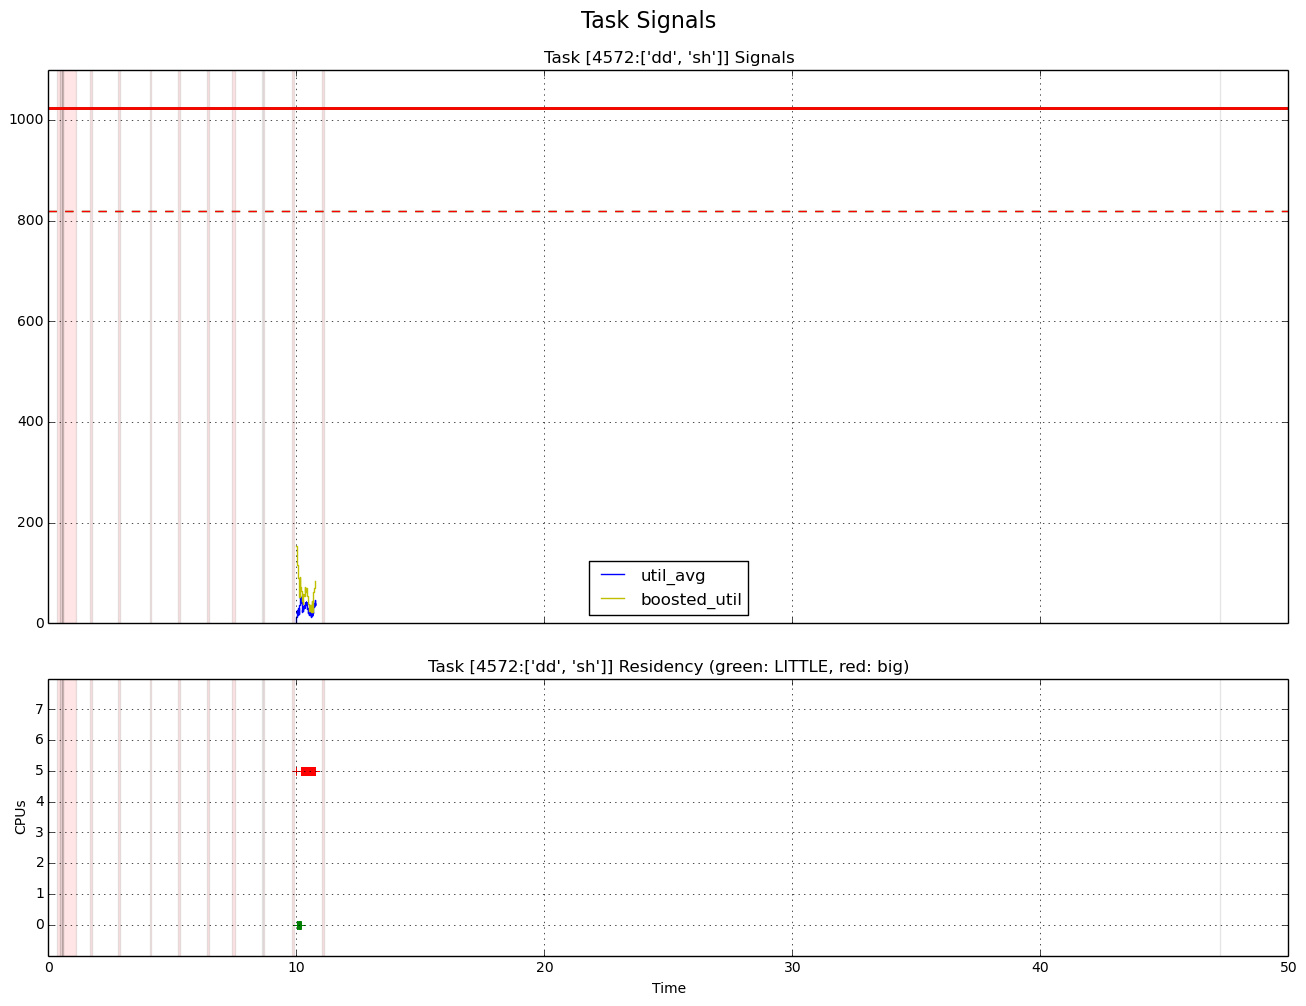

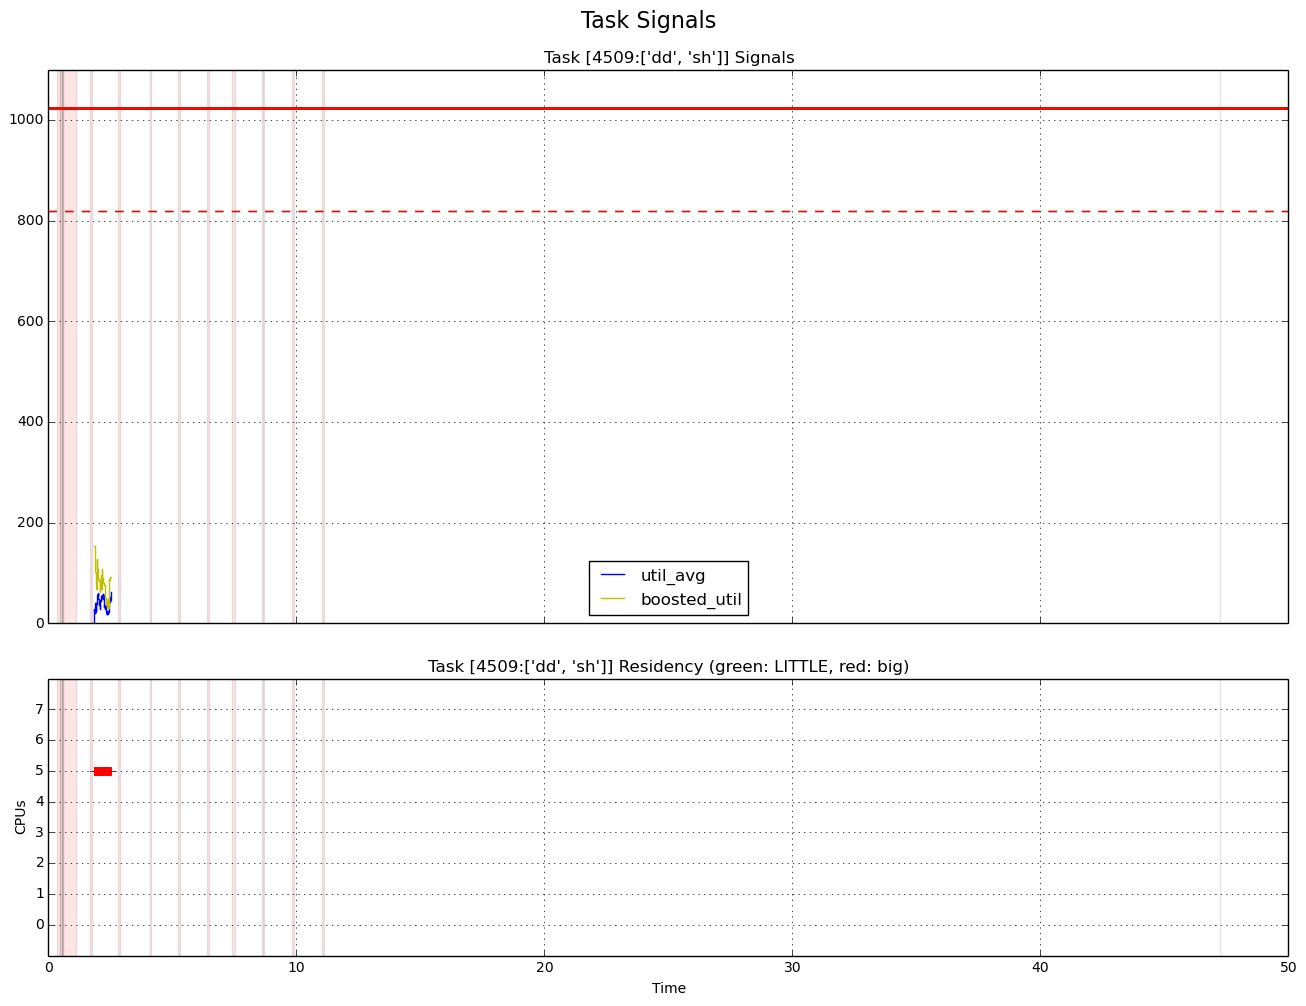

In [12]:
try:
    tasks_an = trace['eas'].analysis.tasks
    tasks_an.plotTasks(tasks=['dd'],
                       signals=['util_avg', 'boosted_util',
                                'sched_overutilized', 'residencies'])
    print "Plotting dd task for [eas]..."
except: pass

In [ ]:
try:
    tasks_an = trace['sfreq'].analysis.tasks
    tasks_an.plotTasks(tasks=['dd'],
                       signals=['util_avg', 'boosted_util',
                                'sched_overutilized', 'residencies'])
    print "Plotting dd task for [sfreq]..."
except: pass

In [ ]:
try:
    tasks_an = trace['sutil_walt'].analysis.tasks
    tasks_an.plotTasks(tasks=['dd'],
                       signals=['util_avg', 'boosted_util',
                                'sched_overutilized', 'residencies'])
    print "Plotting dd task for [sutil_walt]..."
except: pass

In [ ]:
try:
    tasks_an = trace['sutil_pelt'].analysis.tasks
    tasks_an.plotTasks(tasks=['dd'],
                       signals=['util_avg', 'boosted_util',
                                'sched_overutilized', 'residencies'])
    print "Plotting dd task for [sutil_pelt]..."
except: pass

In [ ]:
try:
    tasks_an = trace['sutil_walt'].analysis.tasks
    tasks_an.plotTasks(tasks=['dd'],
                       signals=['util_avg', 'boosted_util',
                                'sched_overutilized', 'residencies'])
    print "Plotting dd task for [sutil_walt]..."
except: pass

## Plot Frequency Residencies

In [14]:
fa = trace['eas'].analysis.frequency

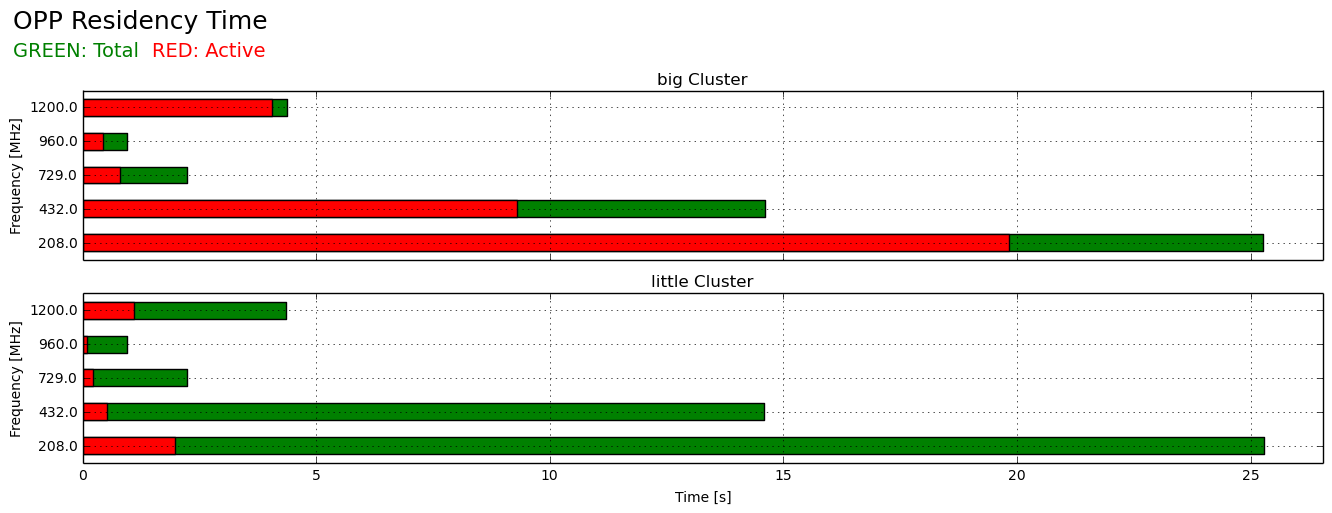

In [15]:
fa.plotClusterFrequencyResidency()

In [19]:
trace['eas'].data_frame.cluster_frequency_residency('big')

,time
frequency,
208.0,25.258090
432.0,14.603937
729.0,2.234832
960.0,0.951424
1200.0,4.365521


In [20]:
trace['eas'].data_frame.cluster_frequency_residency('little')

,time
frequency,
208.0,25.279361
432.0,14.592405
729.0,2.231734
960.0,0.949754
1200.0,4.360726


## Plot Idle State Residencies

In [23]:
idle_analysis = trace['eas'].analysis.idle

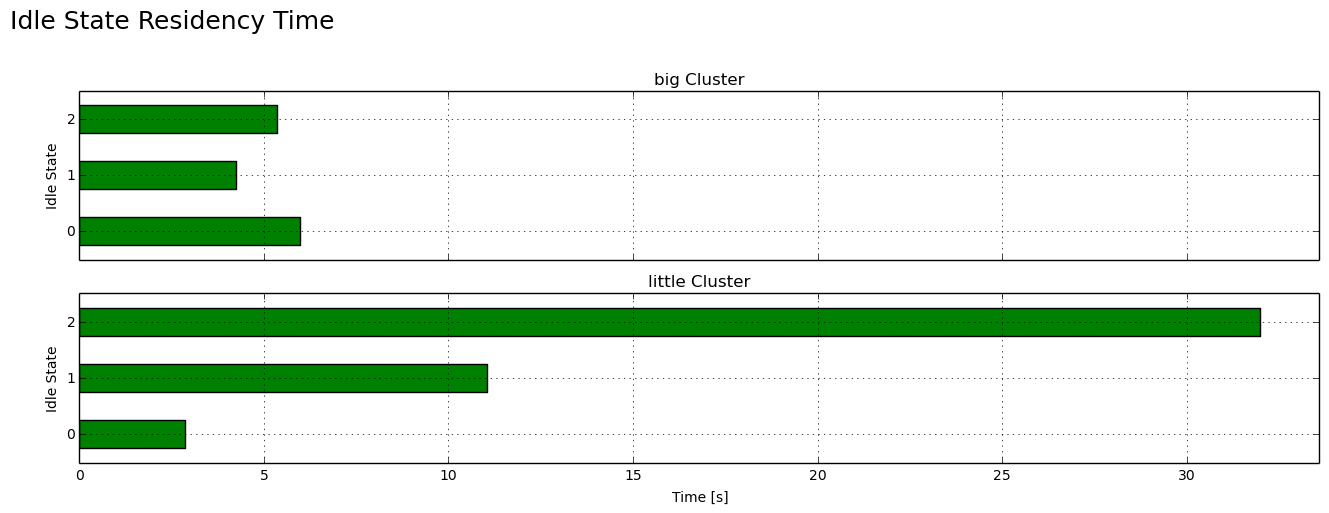

In [24]:
idle_analysis.plotClusterIdleStateResidency()

## Plot CPU-related signals (util_avg, capacity) 

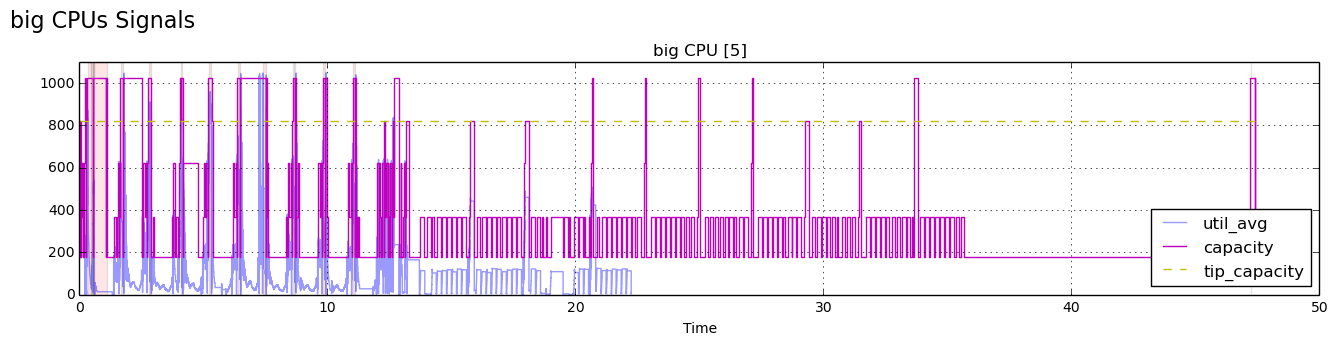

In [31]:
cpus_analysis = trace['eas'].analysis.cpus
cpus_analysis.plotCPU(cpus=[5])